In [7]:
import numpy as np
import torch as t
from torch.distributions import Normal, Categorical, Bernoulli
from torch.distributions import MultivariateNormal as MvNormal
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual
mpl.rcParams['figure.max_open_warning'] = False

ModuleNotFoundError: No module named 'ipympl'

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\Categorical}{{\rm Categorical}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}[1][]{{\rm P}_{#1}\!\b}
\newcommand{\Q}[1][]{{\rm Q}_{#1}\!\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}[1][]{\mathbb{E}_{#1}\!\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\k}{\mathbf{k}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\La}{\mathbf{\Lambda}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sprior}{\S_\text{prior}}
\newcommand{\Spost}{\S_\text{post}}
\newcommand{\mprior}{\m_\text{prior}}
\newcommand{\mpost}{\m_\text{post}}
\newcommand{\Xt}{\tilde{\X}}
\newcommand{\yt}{\tilde{\y}}
\newcommand{\p}{\mathbf{p}}
\newcommand{\q}{\mathbf{q}}
\newcommand{\l}{\boldsymbol{\ell}}
\DeclareMathOperator{\softmax}{softmax}
\newcommand{\z}{\mathbf{z}}
\newcommand{\norm}{\bracket{\lVert}{\rVert}}
\newcommand{\Dkl}[2]{D_\text{KL} \left( #1 \middle\Vert #2 \right)}
$$

<h1> Part 5: Unsupervised learning and clustering </h1>

<h2> Clustering is not classification... </h2>
<h2>...and unsupervised learning is not supervised learning </h2>
Clustering is a type of unsupervised learning, which is very, very different from the supervised learning you have seen in my slides so far.

In supervised learning, we have a list of input, `x`, output, `y`, pairs as data, and the idea is to learn a function that maps from a new input test point, to a distribution over the corresonding `Y`

```
#### Supervised learning
x : X # Input
y : Y # Output
    [(X, Y)] -> (X -> Y) 
```

In unsupervised learning/clustering, we only have a list of inputs, and the goal is to compute a (distribution over) a latent variable that somehow summarises the structure of the inputs.

```
#### Unsupervised learning
x : X # Input
z : Z # Latent
    [X] -> [Z]
```

<h2> First example </h2>

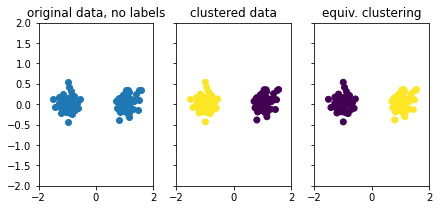

In [3]:
X = t.cat([
    t.randn(50, 2)/5 + t.tensor([1., 0.]),
    t.randn(50, 2)/5 + t.tensor([-1., 0.])
])

Z = t.cat([
    t.zeros(50).int(),
    t.ones(50).int()
])

#fig = plot.figure()

fig, axs = plt.subplots(ncols=3, figsize=(7,3), sharey=True)
axs[0].set_xlim(-2, 2)
axs[1].set_xlim(-2, 2)
axs[2].set_xlim(-2, 2)
axs[0].set_ylim(-2, 2)
axs[0].scatter(X[:, 0], X[:, 1])
axs[1].scatter(X[:, 0], X[:, 1], c=Z);
axs[2].scatter(X[:, 0], X[:, 1], c=-Z);
axs[0].set_title("original data, no labels")
axs[1].set_title("clustered data")
axs[2].set_title("equiv. clustering");

<h3> A classification problem where we need to ignore clusters </h3>

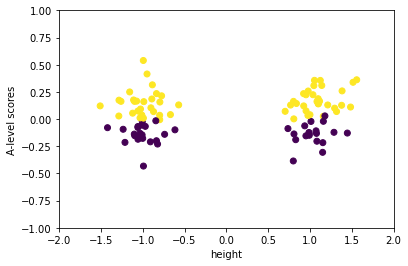

In [4]:
Y = Bernoulli(t.sigmoid(100*X[:, 1])).sample()

fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)
ax.set_xlabel("height")
ax.set_ylabel("A-level scores")
ax.scatter(X[:, 0], X[:, 1], c=Y);

<h2> Simplest clustering algorithm: K-means </h2>

We start by introducing cluster centers,
\begin{align}
  \m_z &= \text{cluster center, for cluster indexed $z$}\\
\end{align}
and integer-valued cluster assignments, $z_i$, describing the cluster associated with the $i$th datapoint,
\begin{align}
  z_i &= \text{integer cluster index for each datapoint, indexed $i$}\\
\end{align}

The objective is find a bunch of cluster centers such that all datapoints are close to a cluster center.  Formally, we minimise the squared distance between each datapoint and its assigned cluster center,

\begin{align}
  \L(\z, \m) &= \sum_i \norm{\x_i - \m_{z_i}}^2
\end{align}

To optimize this algorithm, we use coordinate descent (i.e. we alternate between optimizing $\z$ and $\m$).

First, we assign each datapoint to the nearest cluster,

\begin{align}
  z_i &\leftarrow \argmin_{z\in\{1...Z\}} \norm{\x_i - \m_z}^2
\end{align}

Then, we put the cluster centers at the mean of the assigned datapoints,

\begin{align}
  \m_z &\leftarrow \frac{1}{\sum_i \delta_{z, z_i}} \sum_{i} \delta_{z, z_i} \x_i
\end{align}

remember that $z$ is an index, whereas $z_i$ is the actual cluster assignment for datapoint $i$.

\begin{align}
  \delta_{z, z_i} = 
  \begin{cases}
    1 &\text{if $z=z_i$, i.e. datapoint $i$ is currently assigned to the $z$th cluster}\\
    0 &\text{if $z\neq z_i$, i.e. datapoint $i$ is not in the $z$th cluster}
  \end{cases}
\end{align}

so,

\begin{align}
  \sum_i \delta_{z, z_i} &= \text{number of datapoints in cluster $z$}\\
  \sum_i \x_i \delta_{z, z_i} &= \text{sum of all the datapoints in cluster $z$}
\end{align}

In [5]:
# N == number of datapoints
# K == number of clusters
# D == dimension of the data vectors (usually 2 in our examples)
#X.shape  == (N, 1, D) # Data
#mu.shape ==    (K, D) # Cluster-centers
#q.shape  == (N, K, 1) # One-hot representation of the cluster-assignments for each datapoint
#z.shape  == (N,)      # Cluster index for each datapoint

t.manual_seed(0)

X = t.cat([
    t.randn(50, 2)/5 + t.tensor([1., 0.]),
    t.randn(50, 2)/5,
    t.randn(50, 2)/5 + t.tensor([-1., 0.])
])

def kmeans(X, K):
    N, D = X.shape
    X = X[:, None, :]
    mu = t.randn(K, D)
    while True:
        sd = ((X - mu)**2).sum(-1) # sd.shape = (N, K)
        z = t.argmin(sd, 1)        # z.shape  = (N)
        q = t.zeros(N, K, 1)
        q[t.arange(N), z, 0] = 1.
        print(f"loss = {loss(X, z, mu).item()}")
        plot(X, z, mu)
        yield None
        
        mu = (q * X).sum(0) / q.sum(0)
        print(f"loss = {loss(X, z, mu).item()}")
        plot(X, z, mu)
        yield None
        
def loss(X, z, mu):
    return ((X - mu[z, :][:, None, :])**2).mean()
    
def plot(X, z, mu):
    fig, ax = plt.subplots()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.scatter(X[:, 0, 0], X[:, 0, 1], c=z);
    ax.scatter(mu[:, 0], mu[:, 1], s=100, c='r', label="cluster centers")
    ax.legend()
    
kmeans_iter = iter(kmeans(X, 3))
def kmeans_call():
    next(kmeans_iter)
interact_manual(kmeans_call);

#Change marker type

NameError: name 'interact_manual' is not defined

However, one strange property of this algorithm is that it assumes "hard" cluster assignments.

<h2> Soft clustering and the Gaussian Mixture Model (GMM) </h2>

The goal of the GMM, is really just to model the density of the data we use the latent variables to give us a better model of the data.

For instance, consider fitting a MvNormal to the following data,

In [6]:
X = t.cat([
    t.randn(50, 2)/5 + t.tensor([1., 0.]),
    t.randn(50, 2)/5 + t.tensor([-1., 0.])
])

N = X.shape[0]
mu = X.sum(0)/N
cov = ((X - mu).T @ (X-mu))/N
mvn = MvNormal(mu, cov)

logPx = mvn.log_prob(X).sum()
print(f"logPx = {logPx}")

P = 100
x0s = t.linspace(-2, 2, P)[:, None].expand(P, P)
x1s = x0s.T
xs  = t.stack([x0s.reshape(-1), x1s.reshape(-1)], 1)
ps = mvn.log_prob(xs).exp().view(P, P)

fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.scatter(X[:, 0], X[:, 1]);
ax.contour(x0s, x1s, ps);

logPx = -132.896728515625


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

How do we get a better model for this kind of data?  We use a GMM.

The simplest form of a GMM is a density, with $K$ different Gaussians, in different locations, $\m_k$, and with different covariance matrices, $\S_k$,

\begin{align}
  \P{\x_i} &= \sum_{z=1}^Z p_z \N{\x_i; \m_z, \S_z}.
\end{align}

However, this doesn't give us a way to extract any notion of assignment of a datapoint to a mixture component.

We therefore write this distribution in terms of a latent variable,

\begin{align}
  \P{\x_i} &= \sum_{z_i=1}^Z \P{\x_i| z_i} \P{z_i}
\end{align}

where, $\P{z_i}$ is a Categorical (i.e. a distribution over integers from $1$ to $Z$), and represents the mixture component for the $i$th data point, and $\P{x_i| z_i}$ is a _single_ Gaussian, (corresponding to the $z_i$th mixture component),

\begin{align}
  \P{z_i} &= \Categorical{z_i; \p} = p_{z_i}\\
  \P{\x_i| z_i} &= \N{\x_i; \m_{z_i}, \S_{z_i}}.
\end{align}

The substituting in the values of $\P{z_i}$ and $\P{x_i| z_i}$, we get the same expression as above, except use $z_i$ as the summation index, instead of $z$

\begin{align}
  \P{\x_i} &= \sum_{z_i=1}^Z \P{\x_i| z_i} \P{z_i} = \sum_{z_i=1}^Z p_{z_i} \N{\x_i; \m_{z_i}, \S_{z_i}}.
\end{align}



Now, we can use Bayes theorem to give a posterior distribution over $z_i$,

\begin{align}
  \P{z_i| \x_i} &\propto \P{\x_i| z_i} \P{z_i}
\end{align}

Suggests an algorithm similar to K-means: first compute the posterior over $z_i$ (E-step), then update the parameters of the Gaussians, $\m_z$, using a mean weighted by the posterior (M-step).

In particular, the **E-step** updates the posterior over $z_i$ for a given $x_i$, and "saves" the posterior into $\q$.  The denominator normalizes the distribution so that it sums to 1.
\begin{align}
  q_{i; z} &\leftarrow \P{z_i=z| x_i} = \frac{\P{\x_i| z_i=z} \P{z_i=z}}{\sum_{z'} \P{\x_i| z_i=z'} \P{z_i=z'}}
\end{align}
and the **M-step**, is a weighted average of $\x_i$'s, with the weights corresponding to the degree to which that datapoint is assigned to that cluster,
\begin{align}
  \m_z &\leftarrow \frac{\sum_i \x_i q_{i, z}}{\sum_i q_{i, z}}
\end{align}

In the case where we are very sure about the cluster assignments, the posteriors become equal to the hard-assignment case, because $\P{z_i=z| x_i}$ is $1$ for the "right" assignment and $0$ otherwise,

\begin{align}
  q_{i; z} &= \P{z_i=z| x_i} = \delta_{z_i, z}
\end{align}

In [7]:
t.manual_seed(0)

X = t.cat([
    t.randn(50, 2)/3 + t.tensor([1., 0.]),
    t.randn(50, 2)/3 + t.tensor([-1., 0.])
])

def gmm_em(X, K):
    N, D = X.shape
    X = X[:, None, :]
    mu  = t.randn(K, D)
    cov = 0.5*t.eye(D, D).expand(K, -1, -1)
    while True:
        # unnormalized posterior probability
        q = MvNormal(mu, cov).log_prob(X).exp()
        # normalized posterior probability
        q = q / q.sum(1, keepdim=True)
        # expand out last such that q.shape = (N, K, 1)
        q = q[:, :,  None]
        plot_gmm(X, q, mu, cov)
        yield None
        
        #weighted mean
        mu = (q * X).sum(0) / q.sum(0)
        plot_gmm(X, q, mu, cov)
        yield None

        
def plot_gmm(X, q, mu, cov):
    fig, ax = plt.subplots()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.scatter(X[:, 0, 0], X[:, 0, 1], c=q[:, 0, 0]);
    ax.scatter(mu[:, 0], mu[:, 1], s=100, c='r', label="cluster centers")
    ax.legend()

    
gmm_em_iter = iter(gmm_em(X, 2))
def gmm_em_call():
    next(gmm_em_iter)
interact_manual(gmm_em_call);

#Change marker type

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<h2> What is the objective function for EM? [Non-examinable] </h2>

Turns out that this is a very subtle question.

We need to define an "approximate posterior", corresponding to the current cluster assignments,

\begin{align}
  \Q[\q]{z_i} &= \Categorical{z_i; \q_{i}} = q_{i, z_i}
\end{align}

We can write down the "evidence lower-bound objective" (ELBO).  Note that the "model evidence" is $\log \P{\x}$, and the ELBO can be defined as,

\begin{align}
  \log \P[\m]{\x} \geq \L\b{\m, \q} &= \log \P[\m]{\x}- \Dkl{\Q[\q]{\z}}{\P[\m]{\z| \x}}
\end{align}

Where the ELBO is a lower-bound because the KL-divergence is non-negative,

\begin{align}
  0 \leq \Dkl{\Q[q]{\z}}{\P[\m]{\z| \x}} = \E[{\Q[\q]{\z}}]{\log \frac{\Q[\q]{\z}}{\P[\m]{\z| \x}}}
\end{align}

And the KL-divergence equals zero when the approximate posterior equals the true posterior, $\Q{\z} = \P{\z| \x}$.

<h4> Expectation (E) step </h4>

Thus, the E-step consists of maximizing the ELBO wrt to the parameters of the approximate posterior, $\q$.

\begin{align}
  \q \leftarrow \argmax_{\q} \L\b{\m, \q}
\end{align}

as $\log \P[\m]{\x}$ does not depend on $\q$ this is equivalent to,

\begin{align}
  \q \leftarrow \argmax_{\q} \Dkl{\Q[\q]{\z}}{\P[\m]{\z| \x}} 
\end{align}

This KL-divergence is minimized by setting $\q$ to the true posterior (i.e. the E-step that we saw above), concretely, we can achieve this by setting,

\begin{align}
  q_{i, z} \leftarrow \P{z_i=z| \x_i}.
\end{align}

<h3> Maximization (M) step </h3>

The goal is,
\begin{align}
  \m \rightarrow \argmax_{\m} \L\b{\m, \q}
\end{align}

Both terms in the previous form for the ELBO depend on $\m$,

\begin{align}
  \L\b{\m, \q} &= \log \P[\m]{\x} + \Dkl{\Q[\q]{\z}}{\P[\m]{\z| \x}}
\end{align}

so we need to rearrange to get a good update for $\m$.

In particular,

\begin{align}
  \L\b{\m, \q} &= \log \P[\m]{\x} - \E[{\Q[\q]{\z}}]{\log \frac{\Q[\q]{\z}}{\P[\m]{\z| \x}}}\\
  \L\b{\m, \q} &= \log \P[\m]{\x} + \E[{\Q[\q]{\z}}]{\log \frac{\P[\m]{\z| \x}}{\Q[\q]{\z}}}\\
  \L\b{\m, \q} &= \E[{\Q[\q]{\z}}]{\log \P[\m]{\x} + \log \frac{\P[\m]{\z| \x}}{\Q[\q]{\z}}}\\
  \L\b{\m, \q} &= \E[{\Q[\q]{\z}}]{\log \frac{\P[\m]{\z| \x} \P[\m]{\x}}{\Q[\q]{\z}}}\\
  \L\b{\m, \q} &= \E[{\Q[\q]{\z}}]{\log \frac{\P[\m]{\x, \z}}{\Q[\q]{\z}}}\\
  \L\b{\m, \q} &= \E[{\Q[\q]{\z}}]{\log \P[\m]{\x, \z}} - \E[{\Q[\q]{\z}}]{\Q[\q]{\z}}\\
\end{align}

Note that the second term doesn't depend on $\m$, so,

\begin{align}
  \m \rightarrow \argmax_{\m} \E[{\Q[\q]{\z}}]{\log \P[\m]{\x, \z}}
\end{align}

And this is just maximum-likelihood fitting of the parameters of the mixtures (here, the mixture-means), with datapoints weighted by $\Q{\z}$.